# P5 : Segmentation des clients d'un site e-commerce 

<p><strong>Contexte :</strong> Le client <strong>Olist</strong>, une solution de vente sur les marketplaces en ligne,souhaite obtenir une <strong>Segmentation de ses clients</strong>.</p>
    
<p><strong>Objectif :</strong> Comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.</p>
    
<p><strong>Mission :</strong> Fournir à l’équipe marketing :
<ul>
    <li>une <strong>description actionable</strong> de la segmentation et de sa logique sous-jacente pour une utilisation optimale,</li>
    <li>une <strong>proposition de contrat de maintenance</strong> basée sur une analyse de la stabilité des segments au cours du temps.</li>
</ul>
</p>

<hr/>

# *Partie 1 : Exploration des données*

## I. Importation des Librairies utiles
<p>Plusieurs librairies sont utiles tout au long de l'étude. Elles sont importées dans cette section.</p>

In [1]:
# librairies pour ne pas afficher les warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# librairies pour les graphes
%pylab  inline
import seaborn as sns
from mlxtend.plotting import plot_pca_correlation_graph

Populating the interactive namespace from numpy and matplotlib


In [3]:
# librairies pour les analyses
import pandas as pd
import missingno as msno
import math
from scipy import stats
from datetime import datetime
from functools import reduce
from sklearn import decomposition
from sklearn import preprocessing

<hr/>

## II. Sélection et Importation des Données
<p>Plusieurs données ont été récupérées depuis le site de notre client Olist. Cette section est dédiée à leur importation.</p>

**1. Données des clients**

Ce jeu de données contient des informations sur les clients et leur localisation.

In [4]:
# importation du jeu de données à partir de .csv
customers = pd.read_csv('../Dataset/olist_customers_dataset.csv')

# changement des noms de colonnes
'''Les noms des colonnes concernant la localisation sont changés de façon à être communs
   avec les autres jeux qui ont les mêmes données'''
customers.columns = ['customer_id','customer_unique_id','zip_code_prefix','city','state']

In [5]:
# initialisation des types de données
customers[['customer_id','customer_unique_id','city','state']] = customers[['customer_id','customer_unique_id','city','state']].astype('str')

In [6]:
# suppression des lignes dupliquées
customers = customers.drop_duplicates()

**2. Données géographiques**

Ce jeu de données contient des informations sur les codes postaux brésiliens et ses coordonnées latitude/longitude.

In [7]:
# importation du jeu de données à partir de .csv
geoloc = pd.read_csv('../Dataset/olist_geolocation_dataset.csv')

# changement des noms de colonnes
'''Les noms des colonnes concernant la localisation sont changés de façon à être communs
   avec les autres jeux qui ont les mêmes données'''
geoloc.columns = ['zip_code_prefix','geolocation_lat','geolocation_lng','city','state']


In [8]:
# initialisation des types de données
geoloc[['city','state']] = geoloc[['city','state']].astype('str')

In [9]:
# suppression des lignes dupliquées
geoloc = geoloc.drop_duplicates(subset=['zip_code_prefix','city','state'])

**3. Données des commandes**

Cet ensemble de jeux données comprend des données sur :

* les articles achetés dans chaque commande &emsp; =>&emsp; items

In [10]:
# importation du jeu de données à partir de .csv
items = pd.read_csv('../Dataset/olist_order_items_dataset.csv')

In [11]:
# initialisation des types de données
items[['order_id','product_id','seller_id']] = items[['order_id','product_id','seller_id']].astype('str')
items[['shipping_limit_date']] = items[['shipping_limit_date']].astype('datetime64[ns]')

In [12]:
# suppression des lignes dupliquées
items = items.drop_duplicates()

* les options de paiement &emsp; => &emsp; payments

In [13]:
# importation du jeu de données à partir de .csv
payments = pd.read_csv('../Dataset/olist_order_payments_dataset.csv')

In [14]:
# initialisation des types de données
payments[['order_id','payment_type']] = payments[['order_id','payment_type']].astype('str')

In [15]:
# suppression des lignes dupliquées
payments = payments.drop_duplicates()

D'après les informations obtenues sur le site de notre client, on choisit de transformer les données de paiements des commandes selon leur type de paiements.

In [16]:
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [17]:
# suppression des paiements non définis
payments = payments.loc[payments.payment_type!='not_defined']

* les avis des clients &emsp; => &emsp; reviews

In [18]:
# importation du jeu de données à partir de .csv
reviews = pd.read_csv('../Dataset/olist_order_reviews_dataset.csv')

In [19]:
# initialisation des types de données
reviews[['review_id','order_id','review_comment_title','review_comment_message']] = reviews[['review_id','order_id','review_comment_title','review_comment_message']].astype('str')
reviews[['review_creation_date','review_answer_timestamp']] = reviews[['review_creation_date','review_answer_timestamp']].astype('datetime64[ns]')

In [20]:
# suppression des lignes dupliquées
reviews = reviews.drop_duplicates()

* les différentes commandes &emsp; => &emsp; orders

In [21]:
# importation du jeu de données à partir de .csv
orders = pd.read_csv('../Dataset/olist_orders_dataset.csv')

In [22]:
# initialisation des types de données
orders[['order_id','customer_id']] = orders[['order_id','customer_id']].astype('str')
orders[['order_purchase_timestamp','order_estimated_delivery_date']] = orders[['order_purchase_timestamp','order_estimated_delivery_date']].astype('datetime64[ns]')

In [23]:
# suppression des lignes dupliquées
orders = orders.drop_duplicates()

* les produits vendus par Olist &emsp; => &emsp; products

In [24]:
# importation du jeu de données à partir de .csv
products = pd.read_csv('../Dataset/olist_products_dataset.csv')

In [25]:
# initialisation des types de données
products[['product_id','product_category_name']] = products[['product_id','product_category_name']].astype('str')

In [26]:
# suppression des lignes dupliquées
products =products.drop_duplicates()

**4. Données des commerçants**

Ce jeu de données comprend des données sur les vendeurs qui ont exécuté les commandes passées sur Olist.

In [27]:
# importation du jeu de données à partir de .csv
sellers = pd.read_csv('../Dataset/olist_sellers_dataset.csv')

# changement des noms de colonnes
'''Les noms des colonnes concernant la localisation sont changés de façon à être communs
   avec les autres jeux qui ont les mêmes données'''
sellers.columns = ['seller_id','zip_code_prefix','city','state']

In [28]:
# initialisation des types de données
sellers[['seller_id','city','state']] = sellers[['seller_id','city','state']].astype('str')

In [29]:
# suppression des lignes dupliquées
sellers = sellers.drop_duplicates()

**5. Données des produits**

Ce jeu de données comprend des données sur la traduction en anglais des noms des catégories des produits.

In [30]:
prod_cat = pd.read_csv('../Dataset/product_category_name_translation.csv')

In [31]:
# suppression des lignes dupliquées
prod_cat = prod_cat.drop_duplicates()

<hr/>

## III. Concaténation des Données
<p>Dans cette section, on va combiner les différents jeux de données pour n'en former qu'une seule. C'est le jeu de données résultant qui sera traité dans toute la suite.</p>

In [32]:
'''Concaténation des données clients et leur localisation
   sur la base de code zip'''
data_customer = pd.merge(customers,geoloc,on=['zip_code_prefix','city','state'],how='left')
data_customer = data_customer.drop(['zip_code_prefix','city','state'], axis=1)
data_customer.columns = ['customer_id', 'customer_unique_id', 'customer_lat', 'customer_lng']

In [33]:
'''Concaténation des données commerçants et leur localisation
   sur la base de code zip'''
data_seller = pd.merge(sellers,geoloc,on=['zip_code_prefix','city','state'],how='left')
data_seller = data_seller.drop(['zip_code_prefix','city','state'], axis=1)
data_seller.columns = ['seller_id', 'seller_lat', 'seller_lng']

In [34]:
'''Concaténation des données des produits
   sur la base des catégories des produits'''
data_product = pd.merge(products,prod_cat,on='product_category_name',how='outer')
data_product = data_product.drop('product_category_name', axis=1)

In [35]:
'''Concaténation de tous les données de commandes
   sur la base de l'identifiant de commande'''
data_order = reduce(lambda x,y: pd.merge(x,y,on='order_id',how='left'),
                    [orders,items,payments,reviews])

In [36]:
'''Concaténation de l'ensemble des données
   sur la base de l'identifiant du client et de l'identification du produit'''
data_all = data_order.merge(data_customer,on='customer_id',how='left'
                           ).merge(data_seller,on='seller_id',how='left'
                                  ).merge(data_product,on='product_id',how='left')

In [37]:
data_all.shape

(119151, 37)

<hr/>

## IV. Transformations / Créations de certaines variables
<p>Dans cette section, on transforme certaines variables pour faciliter les analyses et la segmentation.</p>

* On transforme les données paiements en données binaires selon leur type (pour un type donné : 1 si le paiement a été fait par ce type, 0 sinon).

In [40]:
# transformation des données de paiement en one hot encoding
data_all = pd.get_dummies(data=data_all, columns=['payment_type'])

* On crée une variable "temps estimé de livraison en jour", calculée à partir de la différence entre la date de commande et de la date estimée de livraison et transformée en nombre de jours.

In [41]:
data_all['estimated_delivery_days'] = data_all['order_estimated_delivery_date'] - data_all['order_purchase_timestamp']
data_all['estimated_delivery_days'] = data_all['estimated_delivery_days'].apply(lambda d:d.days)

* On crée une variable "distance du commerçcant en km", calculée à partir des coordonées géographiques (lat et lng) du client et de son commerçant.

In [42]:
data_all['seller_distance'] = 6371 * np.arccos((np.sin(data_all['seller_lat'])*np.sin(data_all['customer_lat']))+
                                               (np.cos(data_all['seller_lat'])*np.cos(data_all['customer_lat'])*np.cos(data_all['seller_lng']-data_all['customer_lng'])))

* On crée une variable "taille de categorie", calculée à partir des types de catégorie des produits.

In [43]:
data_all['product_category_name_english'].fillna(value='', inplace=True)
data_all['product_category_lenght'] = data_all['product_category_name_english'].apply(lambda x: len(x))

* On crée une variable "taille de message", calculée à partir des messages en commentaire (review_comment_message).

In [44]:
data_all['review_comment_message'].fillna(value='', inplace=True)
data_all['review_comment_lenght'] = data_all['review_comment_message'].apply(lambda x: len(x))

* On crée une variable "nombre de jour sans commande", calculée à partir de la différence de chaque date de commande pour chaque client

In [45]:
data_all = data_all.sort_values(by=['customer_unique_id','order_purchase_timestamp']).reset_index(drop=True)
data_all['date_off'] = data_all.groupby(['customer_unique_id'])['order_purchase_timestamp'].diff()
data_all['day_off'] = data_all['date_off'].apply(lambda d:d.days).fillna(0)

In [46]:
data_all.shape

(119151, 46)

<hr/>

## V. Gestion des valeurs manquantes
<p> On identifie les valeurs manquantes par colonnes et on les remplace en fonction de leur nature (catégorielle ou numérique) et du produit.</p>
<p><strong>Observation :</strong> Durant cette étape,
<ul>
    <li>on se contentera de remplacer les données manquantes, aucune suppression ne sera réalisée,</li>
    <li>on n'effectuera ces opérations que pour certaines variables utiles dans la suite de l'étude.</li>
</ul>
</p>

<AxesSubplot:>

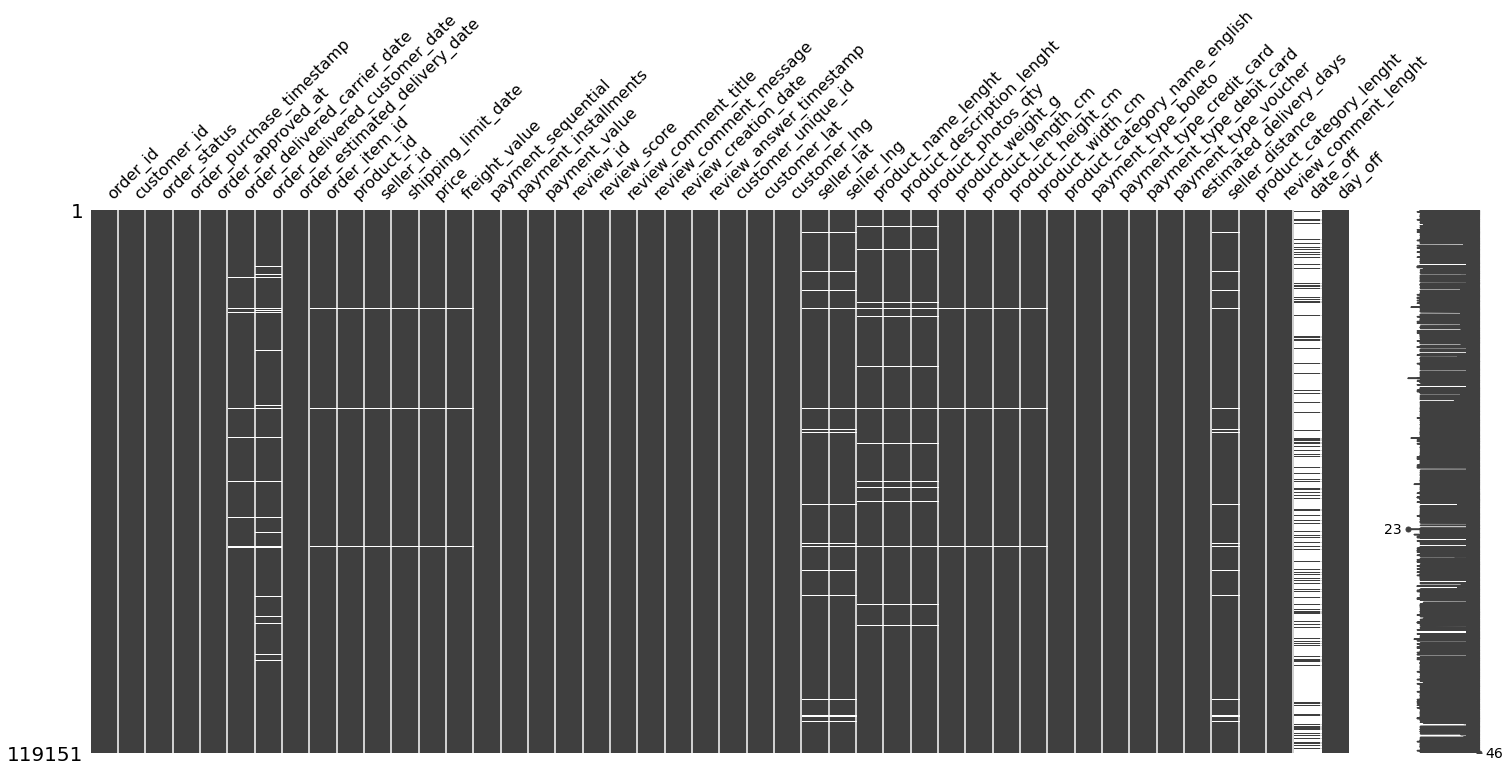

In [47]:
msno.matrix(data_all)

* **Variable catégorielle**

La seule variable catégorielle qui nous intéresse est <strong>nom de la catégorie du produit</strong>.
<p>L'idée est donc d'identifier ces valeurs manquantes et de les remplacer par :
<ul>
    <li>le nom de la catégorie de produit ayant le même identifiant,</li>
    <li>ou la valeur ' ' (vide) le cas échéant.</li>
</ul>
</p>

In [48]:
col_cat = 'product_category_name_english'
index_cat = data_all.loc[pd.isna(data_all[col_cat]),:].index
for i in index_cat :
    prod = data_all.loc[i,'product_id']
    name_value = data_all.product_category_name_english[data_all.product_id==prod].values[0]
    if pd.isna(name_value):
        name_value = ''
    data_all.loc[i,'product_category_name_english'] = name_value

* **Variable numérique**

<p>Les variables numériques qui nous intéressent ici sont : <strong>distance du vendeur, taille de la description du produit, nombre de photos</strong>.</p>

<p>Pour ces variables, l'étape consiste à identifier les valeurs manquantes pour les variables numériques, et de les remplacer par la médiane de la colonne, en filtrant sur :
<ul>
    <li>l'identifiant du client (pour le cas de la distance du commerçant),</li>
    <li>l'identifiant du produit (pour les autres variables).</li>
</ul>
Si la commande ne présente ni un client, ni un produit semblable à d'autres données, la valeur manquante de la variable est remplacée par la médiane de toutes les valeurs de cette variable (toutes données confondues).
</p>

In [77]:
col_num = ['seller_distance','payment_installments','product_description_lenght','product_photos_qty',
           'freight_value','price']

for col in col_num:
    index_num = data_all.loc[pd.isna(data_all[col]),:].index
    if col == 'seller_distance':
        var = 'customer_unique_id'
    else:
        var = 'product_id'
    for i in index_num :
        var_value = data_all.loc[i,var]
        var_median = np.nanmedian(data_all[col][data_all[var]==var_value])
        if pd.isna(var_median):
            var_median = np.nanmedian(data_all[col])
        data_all.loc[i,col] = var_median

In [103]:
data_all.shape

(119151, 46)

<hr/>

***NB*** **: Enregistrement des données avant toute transformation**

In [101]:
data_all.to_csv('../Dataset/data_all.csv')

<hr/>

## VI. Aggrégations des données
<p>On procède, dans cette section, à l'aggrégation des données selon l'identification unique des clients.</p>

In [79]:
data_grouped = data_all.groupby('customer_unique_id')

In [80]:
len(data_grouped)

96096

***Observation :*** On retrouve bien le nombre de clients d'Olist.

<hr/>

## VII. Créations des features
<p>Ici, on sélectionnera les features qui serviront pour le clustering.</p>

* On commence par créer un dataframe qui va contenir les features qu'on va étudier pour la suite.

In [81]:
x_features = pd.DataFrame()

* On crée les variables pour une segmentation RFM (pour chaque client)

In [82]:
# recence : date de la dernière commande
x_features['recence']=data_grouped['order_purchase_timestamp'].max()
date_max = x_features['recence'].max()
x_features['recence']=date_max - x_features['recence']
x_features['recence']=x_features['recence'].apply(lambda d:d.days)

# frequence : nombre des commandes passées
x_features['frequence']=data_grouped['order_id'].count()

# montant : montant total de commandes
x_features['montant']=data_grouped['price'].sum()

* On crée d'autres variables montrant les préférences de types de paiements des clients

In [83]:
# nombre de versements pour les paiements
x_features['n_payment'] = data_grouped['payment_installments'].mean()

# nombre de paiements par carte de crédit
x_features['pay_credit_card'] = data_grouped['payment_type_credit_card'].sum()

# nombre de paiements par carte de débit
x_features['pay_debit_card'] = data_grouped['payment_type_debit_card'].sum()

# nombre de paiements par billets
x_features['pay_boleto'] = data_grouped['payment_type_boleto'].sum()

# nombre de paiements par voucher
x_features['pay_voucher'] = data_grouped['payment_type_voucher'].sum()

* On crée d'autres variables montrant les préférences des clients par rapport aux vendeurs

In [84]:
# distance des vendeurs (maximum)
x_features['seller_distance'] = data_grouped['seller_distance'].max()

# frais de transport
x_features['freight_value'] = data_grouped['freight_value'].max()

# temps de livraison
x_features['estimated_delivery_days'] = data_grouped['estimated_delivery_days'].max()

* On crée d'autres variables montrant les préférences des clients concernant la description des marchandises

In [85]:
# taille de description des produits
x_features['product_description_lenght'] = data_grouped['product_description_lenght'].min()

# tailles de description des catégories des produits
x_features['product_category_lenght'] = data_grouped['product_category_lenght'].mean()

# nombre de photos
x_features['product_photos_qty'] = data_grouped['product_photos_qty'].min()

* On crée d'autres variables montrant les comportements des clients

In [86]:
# nombre de jours sans faire de commande
x_features['day_off'] = data_grouped['day_off'].mean()

# note moyenne de commande
x_features['review_score'] = data_grouped['review_score'].mean()

# tailles de message laissés en commentaire
x_features['review_comment_lenght'] = data_grouped['review_comment_lenght'].mean()

In [87]:
x_features.shape

(96096, 17)

<hr/>

## VIII. Analyses exploratoires
<p>Cette section est dédiée aux analyses exploratoires.</p>

### 1. Description du jeu
<p>On récupère les informations du dataframe.</p>

In [90]:
x_features.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   recence                     96096 non-null  int64  
 1   frequence                   96096 non-null  int64  
 2   montant                     96096 non-null  float64
 3   n_payment                   96096 non-null  float64
 4   pay_credit_card             96096 non-null  uint8  
 5   pay_debit_card              96096 non-null  uint8  
 6   pay_boleto                  96096 non-null  uint8  
 7   pay_voucher                 96096 non-null  uint8  
 8   seller_distance             96096 non-null  float64
 9   freight_value               96096 non-null  float64
 10  estimated_delivery_days     96096 non-null  int64  
 11  product_description_lenght  96096 non-null  float64
 12  product_category_lenght     96096 n

***Observation :*** On voit ici que l'étape de gestion des données manquantes a bien été réalisées.

* On fait une briève description des variables numériques

In [91]:
x_features.describe()

,recence,frequence,montant,n_payment,pay_credit_card,pay_debit_card,pay_boleto,pay_voucher,seller_distance,freight_value,estimated_delivery_days,product_description_lenght,product_category_lenght,product_photos_qty,day_off,review_score,review_comment_lenght
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,287.735691,1.239916,149.198228,2.902420,0.913503,0.017753,0.241321,0.067276,8540.837689,20.475168,23.490176,780.746254,12.553517,2.197167,1.121785,4.069267,31.081559
std,153.414676,0.853318,249.246097,2.678851,0.746311,0.153889,0.580622,0.572776,5614.100887,16.076040,8.863909,644.039720,5.587266,1.722309,10.847173,1.353879,48.302318
min,0.000000,1.000000,0.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,163.000000,1.000000,49.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3732.573688,13.460000,18.000000,348.000000,10.000000,1.000000,0.000000,4.000000,3.000000
50%,268.000000,1.000000,89.900000,2.000000,1.000000,0.000000,0.000000,0.000000,8132.410876,16.500000,23.000000,600.000000,13.000000,1.000000,0.000000,5.000000,3.000000
75%,397.000000,1.000000,159.900000,4.000000,1.000000,0.000000,0.000000,0.000000,12955.841628,21.520000,28.000000,971.000000,14.000000,3.000000,0.000000,5.000000,43.000000
max,772.000000,75.000000,13440.000000,24.000000,24.000000,7.000000,20.000000,75.000000,20001.946690,409.680000,155.000000,3992.000000,39.000000,20.000000,304.000000,5.000000,208.000000


### 2. Répartition des données

* On regarde le comportement des données avec des boîtes à moustaches.

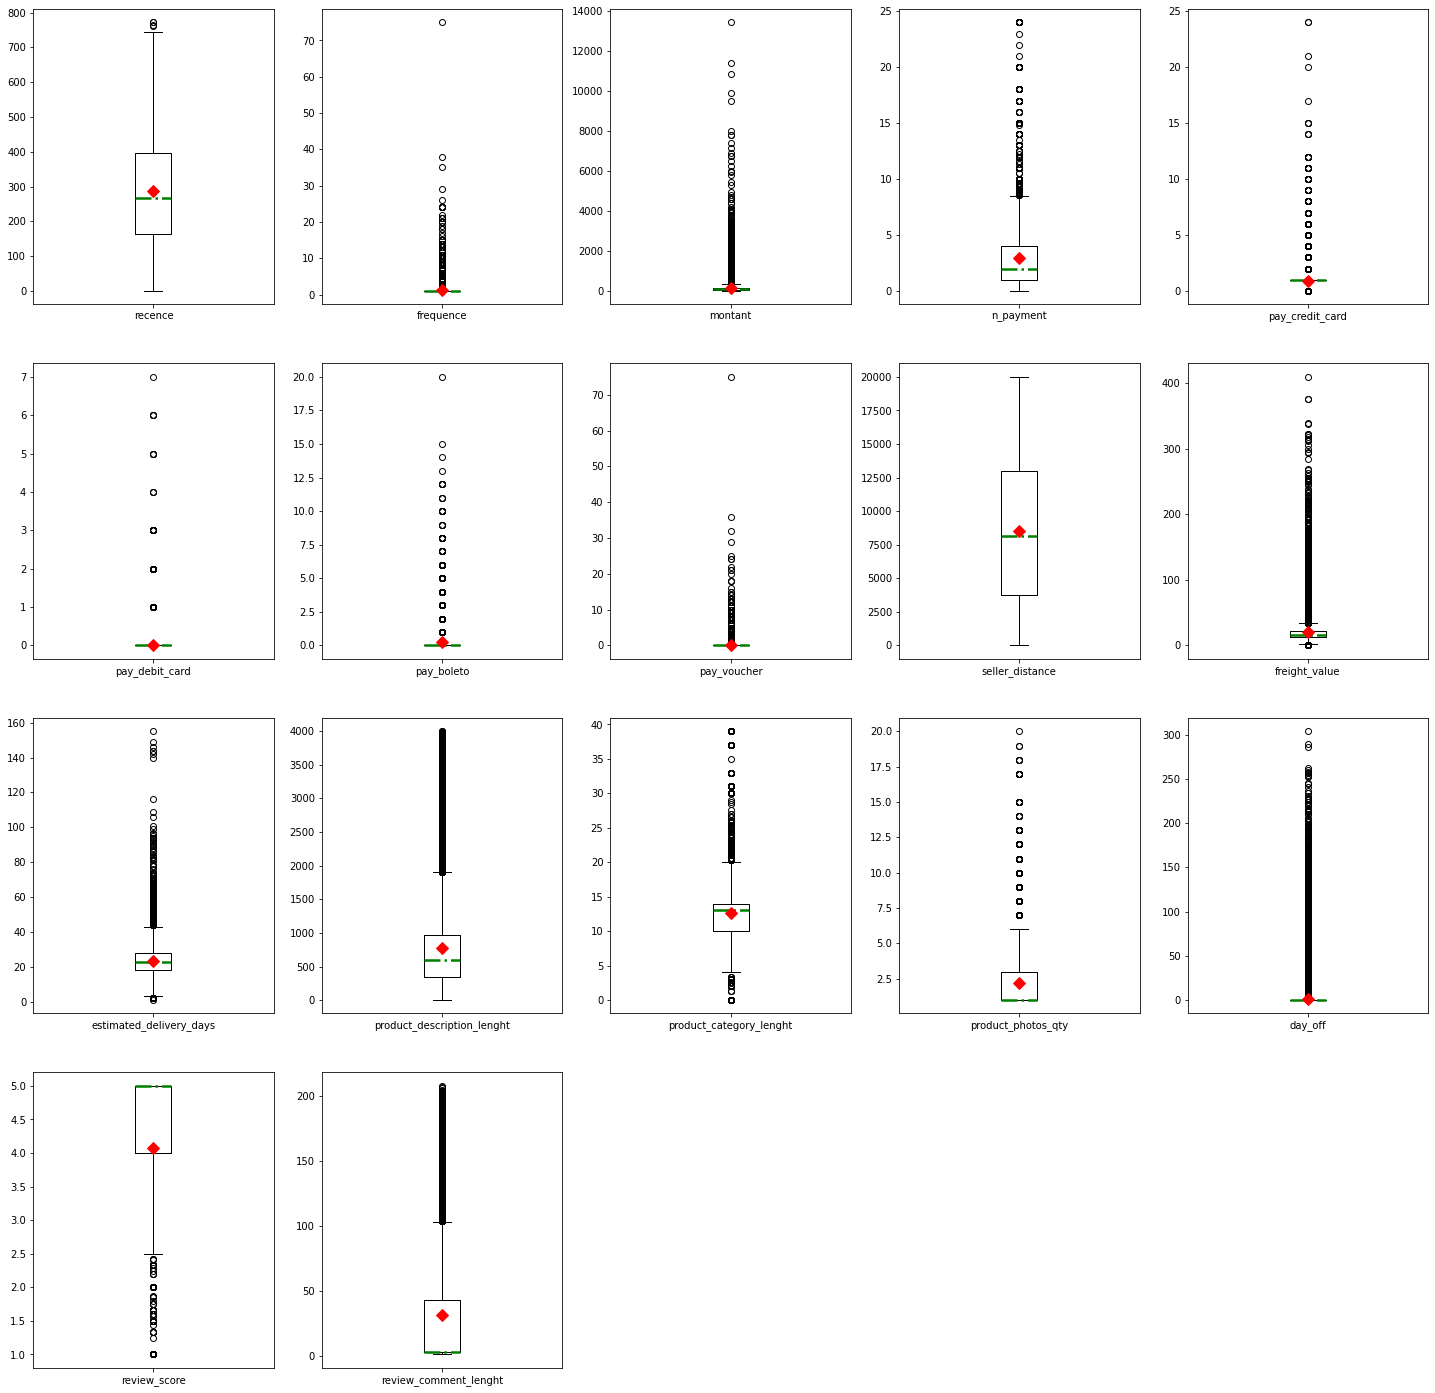

In [92]:
medianprops = dict(linestyle='-.', linewidth=2.5, color='green')
meanpointprops = dict(marker='D',markerfacecolor='red',markeredgecolor='red',markersize=8)

fig = plt.figure(figsize=(25,25))
for i in range(len(x_features.columns)):
    data = x_features[x_features.columns[i]]
    plt.subplot(4,5,i+1)
    plt.boxplot(data,showmeans=True,medianprops=medianprops,meanprops=meanpointprops)
    plt.xticks(ticks=[1],labels=[x_features.columns[i]])

In [109]:
x_features.columns

Index(['recence', 'frequence', 'montant', 'n_payment', 'pay_credit_card',
       'pay_debit_card', 'pay_boleto', 'pay_voucher', 'seller_distance',
       'freight_value', 'estimated_delivery_days',
       'product_description_lenght', 'product_category_lenght',
       'product_photos_qty', 'day_off', 'review_score',
       'review_comment_lenght'],
      dtype='object')

Text(0.5, 1.0, 'NOTES DES CLIENTS')

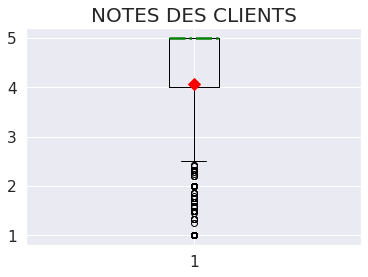

In [119]:
cooo = 'review_score'
daaa = x_features[cooo]
plt.boxplot(daaa,showmeans=True,medianprops=medianprops,meanprops=meanpointprops)
plt.title('NOTES DES CLIENTS',fontsize=20)

***Observation :*** Il ne semble pas avoir de outlier dans les données numériques.

* On continue donc en regardant la distribution de ces variables numériques.

array([[<AxesSubplot:title={'center':'recence'}>,
        <AxesSubplot:title={'center':'frequence'}>,
        <AxesSubplot:title={'center':'montant'}>,
        <AxesSubplot:title={'center':'n_payment'}>],
       [<AxesSubplot:title={'center':'pay_credit_card'}>,
        <AxesSubplot:title={'center':'pay_debit_card'}>,
        <AxesSubplot:title={'center':'pay_boleto'}>,
        <AxesSubplot:title={'center':'pay_voucher'}>],
       [<AxesSubplot:title={'center':'seller_distance'}>,
        <AxesSubplot:title={'center':'freight_value'}>,
        <AxesSubplot:title={'center':'estimated_delivery_days'}>,
        <AxesSubplot:title={'center':'product_description_lenght'}>],
       [<AxesSubplot:title={'center':'product_category_lenght'}>,
        <AxesSubplot:title={'center':'product_photos_qty'}>,
        <AxesSubplot:title={'center':'day_off'}>,
        <AxesSubplot:title={'center':'review_score'}>],
       [<AxesSubplot:title={'center':'review_comment_lenght'}>,
        <AxesSubplot:>, <

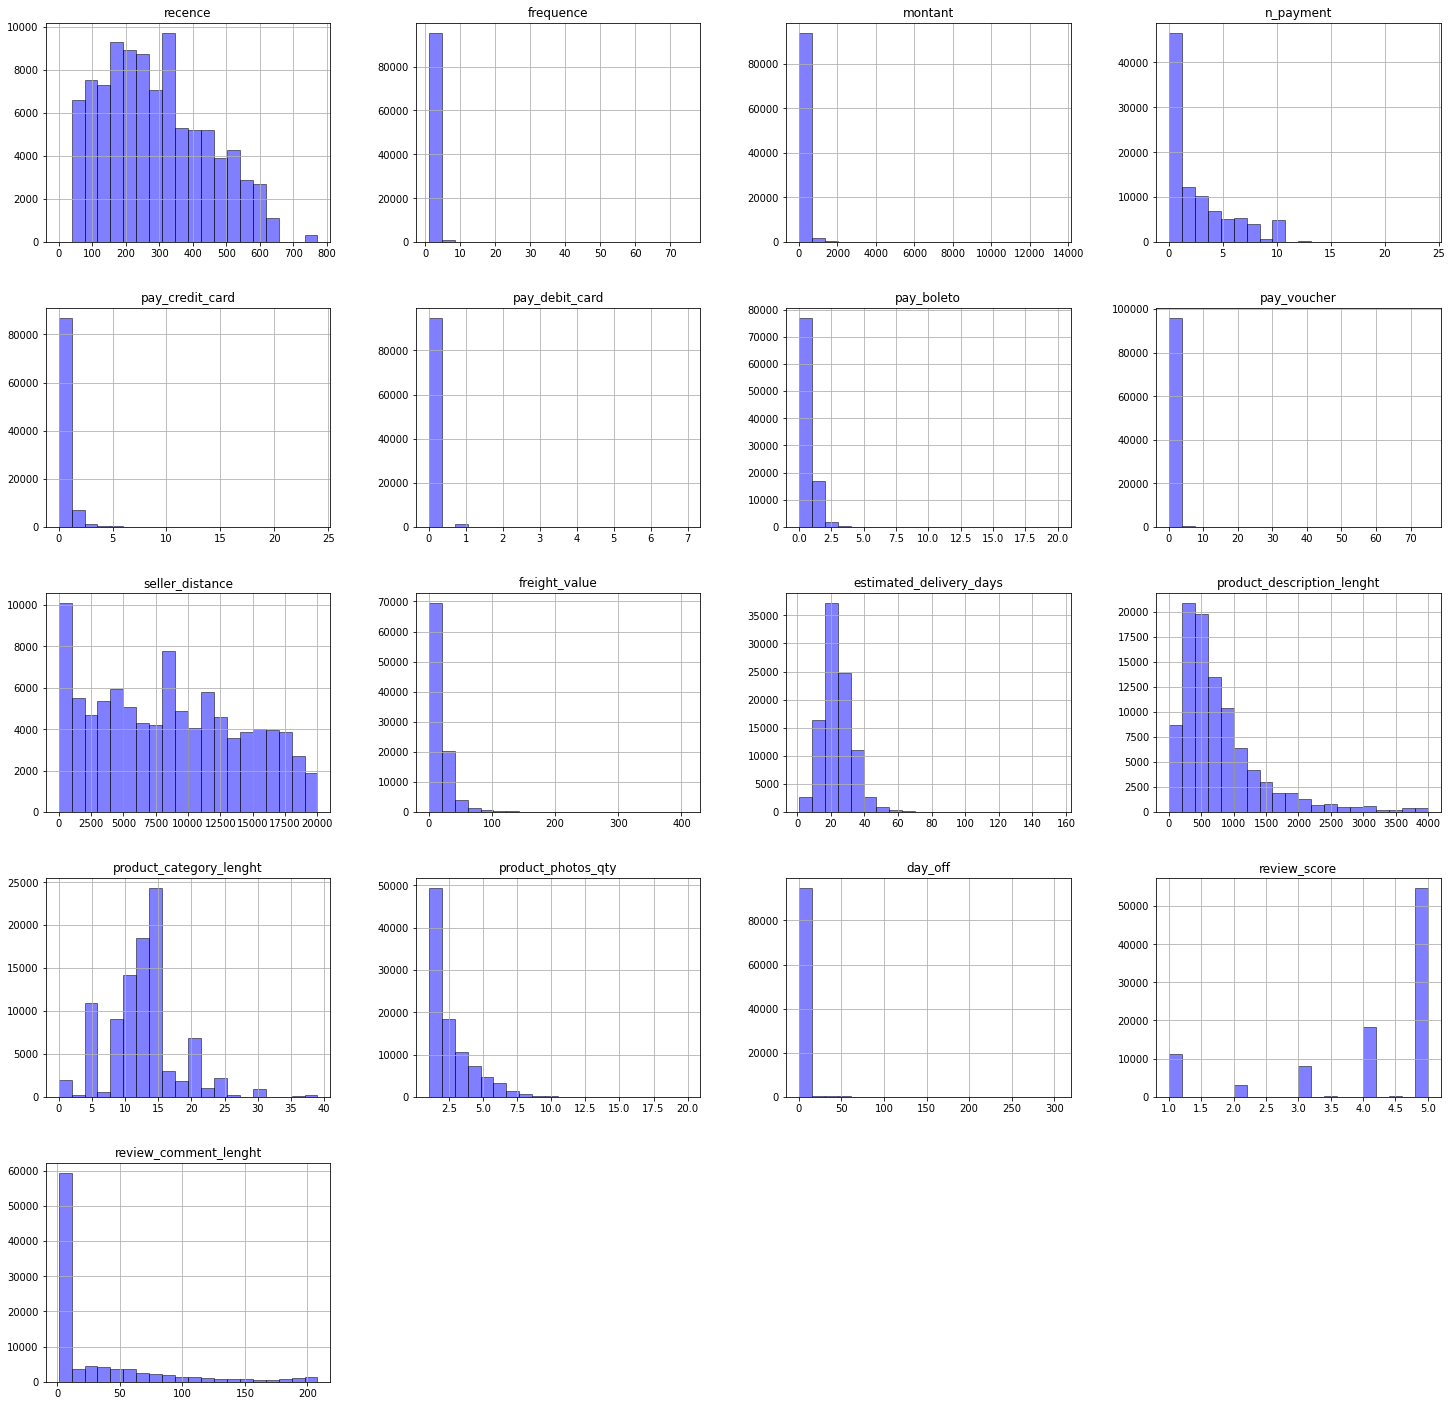

In [93]:
x_features.hist(bins=20,figsize=(25,25),color='b', edgecolor='k', alpha=0.5)

### 3. Corrélation
<p> La corrélation étudiée est celle Pearson.</p>

In [94]:
corr = x_features.corr(method='pearson')

<AxesSubplot:>

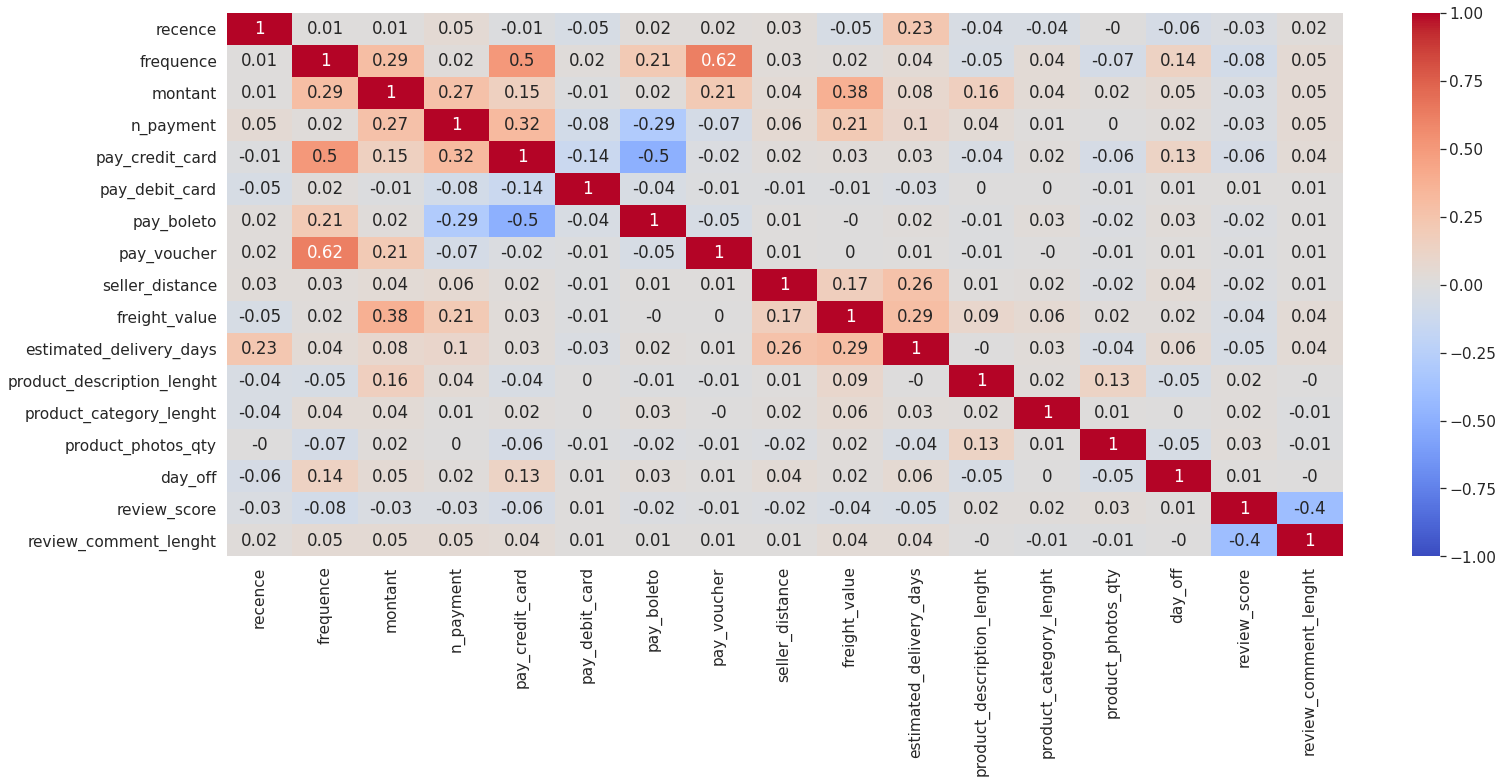

In [108]:
plt.figure(figsize=(25,10))
sns.set(font_scale=1.4)
sns.heatmap(corr.round(2),annot=True,vmin=-1,vmax=1,cmap='coolwarm')

### 4. ACP
<p> (Pour les variables numériques uniquement)

In [96]:
# transformer les données en array numpy
X = x_features

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

(-0.7, 0.7)

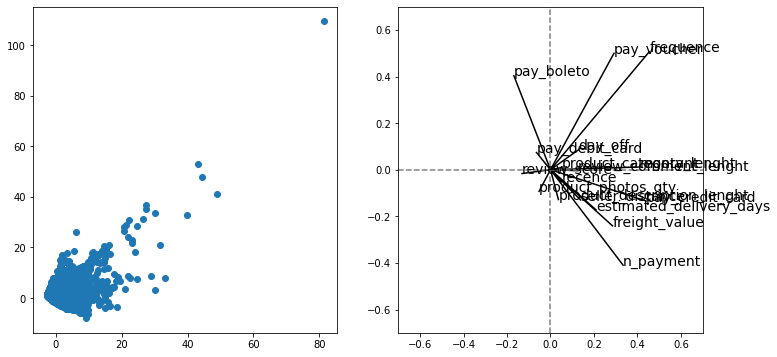

In [97]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
ax1.scatter(X_projected[:, 0], X_projected[:, 1])
#ax1.set_xlim([-5.5, 5.5])
#ax1.set_ylim([-4, 4])

# afficher le cercle de correlation
pcs = pca.components_
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    ax2.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    ax2.text(x, y, X.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
ax2.plot([-.7, .7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
ax2.plot([0, 0], [-.7,.7], color='grey', ls='--')
ax2.set_xlim([-.7,.7])
ax2.set_ylim([-.7,.7])

<hr/>

## IX. Sauvegarde des données
<p>Les données d'intérêt, traitées et analysées seront exportées en format .csv pour faciliter la suite de l'étude.</p>

In [98]:
x_features.to_csv('../Dataset/x_features.csv')